In [8]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

2024-08-02 19:26:19.366338: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-02 19:26:19.366452: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-02 19:26:19.372667: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-02 19:26:19.410467: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-02 19:26:21.898598: W tensorflow/compiler/tf2

In [9]:
url = "https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"

dataset = tf.keras.utils.get_file("stack_overflow", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'stack_overflow')

6053168/6053168 [==============================] - 1s 0us/step


In [20]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)


['javascript', 'csharp', 'python', 'java']

In [13]:
sample_file = os.path.join(train_dir, 'java/9.txt')
with open(sample_file) as f:
  print(f.read())

"importing two different classes with same name from different packages i imported class logger from package blank.util.logging by using import blank.util.logging.logger. in addition to that, as per requirement i need to import user created class from some other package. but the problem is, that class name also logger[created in user defined package]. i don't have permissions to change the name of that user defined class and package. both classes have the static methods...so i need to import two both classes, then what is feasible solution for this?"



In [14]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


2024-08-02 19:46:48.477361: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-02 19:46:48.725995: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-02 19:46:48.726056: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-02 19:46:48.730287: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-02 19:46:48.730377: I external/local_xla/xla/stream_executor

In [15]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second constructor and use it in that class. but it only uses the default constru

In [17]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])
print("Label 2 corresponds to", raw_train_ds.class_names[2])
print("Label 3 corresponds to", raw_train_ds.class_names[3])

Label 0 corresponds to csharp
Label 1 corresponds to java
Label 2 corresponds to javascript
Label 3 corresponds to python


In [18]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [21]:
test_dir = os.path.join(dataset_dir,'test')
os.listdir(test_dir)

['javascript', 'csharp', 'python', 'java']

In [22]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    test_dir,
    batch_size=batch_size)

Found 8000 files belonging to 4 classes.


In [23]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [24]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [25]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [26]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [27]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'"set blank to quit on exception? i\'m using blank 3..i\'ve been looking around for an answer to this, but i haven\'t found it yet. basically, i\'m running several blank scripts into a game engine, and each script has its own entry point...i\'d rather not add try: except blocks through all of my code, so i was wondering if it\'s at all possible to tell blank to quit (or perhaps assign a custom function to that ""callback"") on finding its first error, regardless of where or what it found? ..currently, the game engine will continue after finding and hitting an error, making it more difficult than necessary to diagnose issues since running into one error may make a subsequent script not work (as it relies on variables that the error-ing script set, for example). any ideas? ..i know that i could redirect the console to a file to allow for easier scrolling, but just capturing the first error and stopping the game prematurely would be really useful...okay, a couple of extr

In [28]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  scissors
 313 --->  source
Vocabulary size: 10000


In [29]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [30]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [31]:
# Create Model 
embedding_dim = 16

In [32]:
model = tf.keras.Sequential([
  layers.Embedding(max_features, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(4, activation='sigmoid')])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160000    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 4)                 68        
                                                                 
Total params: 160068 (625.27 KB)
Trainable params: 160068 (625.27 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [34]:
model.compile(loss=losses.SparseCategoricalCrossentropy(),
              optimizer='adam',
              metrics=['accuracy'])

In [36]:
epochs = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/20
  1/200 [..............................] - ETA: 2s - loss: 1.1181 - accuracy: 0.5312

200/200 [==============================] - 2s 12ms/step - loss: 1.0113 - accuracy: 0.7147 - val_loss: 0.9932 - val_accuracy: 0.7387
Epoch 2/20
200/200 [==============================] - 3s 13ms/step - loss: 0.9427 - accuracy: 0.7386 - val_loss: 0.9330 - val_accuracy: 0.7437
Epoch 3/20
200/200 [==============================] - 3s 14ms/step - loss: 0.8810 - accuracy: 0.7633 - val_loss: 0.8800 - val_accuracy: 0.7600
Epoch 4/20
200/200 [==============================] - 3s 14ms/step - loss: 0.8277 - accuracy: 0.7791 - val_loss: 0.8358 - val_accuracy: 0.7675
Epoch 5/20
200/200 [==============================] - 2s 12ms/step - loss: 0.7802 - accuracy: 0.7891 - val_loss: 0.7959 - val_accuracy: 0.7744
Epoch 6/20
200/200 [==============================] - 2s 12ms/step - loss: 0.7407 - accuracy: 0.7953 - val_loss: 0.7619 - val_accuracy: 0.7825
Epoch 7/20
200/200 [==============================] - 3s 13ms/step - loss: 0.7001 - accuracy: 0.8112 - val_loss: 0.7314 - val_accuracy: 0.7856
Epoch 8/20

In [37]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

250/250 [==============================] - 1s 5ms/step - loss: 0.5812 - accuracy: 0.7950
Loss:  0.5811867117881775
Accuracy:  0.7950000166893005


In [38]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

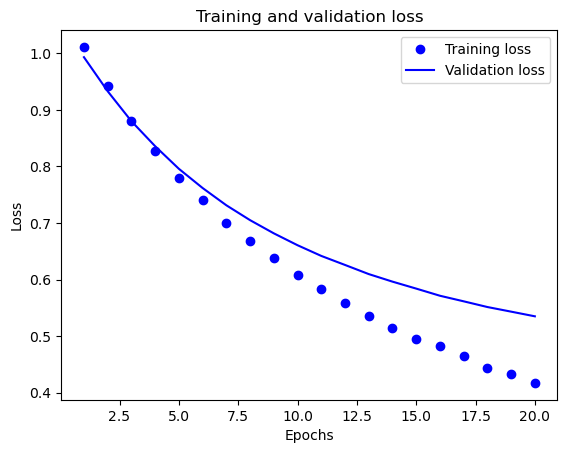

In [40]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

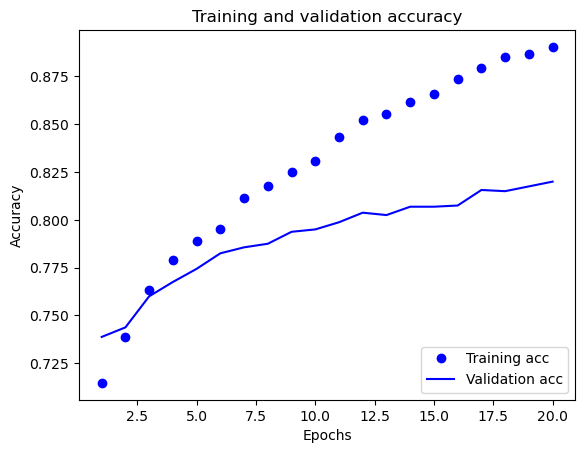

In [41]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [43]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

250/250 [==============================] - 2s 8ms/step - loss: 1.1045 - accuracy: 0.7950
0.7950000166893005


In [ ]:
examples = tf.constant([
 
])

export_model.predict(examples)